# Pipeline for the anomaly detection on the SKAB using Feed Forward Autoencoder

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

## Libraries importing

In [3]:
# libraries importing
import sys
import warnings

import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

sys.path.append("..")
from core.Vanilla_AE import Vanilla_AE
from core.metrics import chp_score
from core.utils import plot_results

sys.path.append("../../odmd-subid-cpd")
from functions.datasets import load_cats

warnings.filterwarnings("ignore", category=UserWarning)

## Data

In [4]:
df = load_cats(
    file_path="/Users/mw/pyprojects/odmd-subid-cpd/examples/data/cats/data.csv",
    resample_s=60,
)
df = df.rename(columns={"y": "anomaly"})
X = df[
    [
        "bed1",
        "bed2",
        "bfo1",
        "bfo2",
        "bso1",
        "bso2",
        "bso3",
        "ced1",
        "cfo1",
        "cso1",
        "aimp",
        "amud",
        "adbr",
        "adfl",
    ]
]
Y = df[["anomaly", "category"]]
Xy_traintest_list = [
    train_test_split(
        X,
        Y,
        train_size=int(1e6 / 60),
        shuffle=False,
        random_state=0,
    )
]

## Method

### Method initialization

In [5]:
# hyperparameters selection
BEST_PARAMS = [5, 4, 2, 0.005, 32]
Q = 0.99  # quantile for upper control limit (UCL) selection

In [6]:
# model defining
model = Vanilla_AE(BEST_PARAMS)

### Method fitting and applying

In [7]:
# inference
predicted_outlier, predicted_cp = [], []
true_outlier, true_cp = [], []
for X_train, X_test, y_train, y_test in Xy_traintest_list:
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)

    # model fitting
    model.fit(StSc.transform(X_train))

    # results predicting
    residuals_train = (
        pd.DataFrame(
            StSc.transform(X_train) - model.predict(StSc.transform(X_train))
        )
        .abs()
        .sum(axis=1)
    )
    UCL = residuals_train.quantile(Q) * 5 / 2

    df_sc = StSc.transform(X_test)
    residuals_full_df = df_sc - model.predict(df_sc)
    residuals_full_df = pd.DataFrame(residuals_full_df).abs().sum(axis=1)

    prediction = pd.Series(
        (residuals_full_df > UCL).astype(int).values, index=X_test.index
    ).fillna(0)

    # predicted outliers saving
    predicted_outlier.append(prediction)

    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

    true_outlier.append(y_test["anomaly"])
    true_cp.append(y_test["anomaly"].diff().abs().fillna(0.0))

521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
2082/2082 ━━━━━━━━━━━━━━━━━━━━ 2s 781us/step


### Results visualization

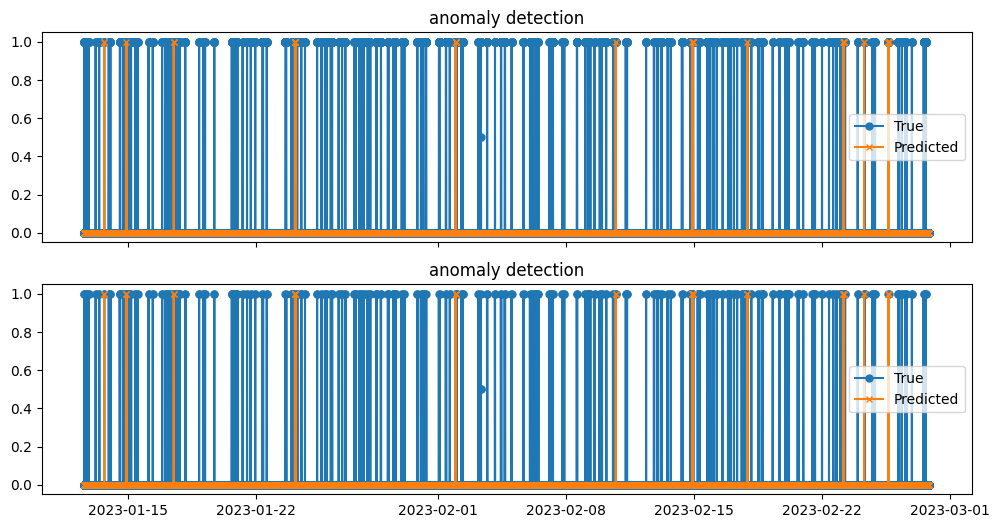

In [8]:
# [donotremove]
plot_results(
    (true_outlier[0], predicted_outlier[0]),
    (true_cp[0], predicted_cp[0]),
)

## Evaluation (metrics calculation)

In [9]:
import pickle

pickle.dump(
    predicted_outlier,
    open(f"../results/results-cats-{model.__class__.__name__}.pkl", "wb"),
)

### Binary classification (outlier detection) metrics

In [10]:
# [donotremove]
# binary classification metrics calculation
binary = chp_score(true_outlier, predicted_outlier, metric="binary")

False Alarm Rate 0.0 %
Missing Alarm Rate 97.83 %
F1 metric 0.04


### Changepoint detection metrics

In [11]:
# [donotremove]
# average detection delay metric calculation
add = chp_score(
    true_cp,
    predicted_cp,
    metric="average_time",
    window_width="18000s",
    anomaly_window_destination="righter",
)

Amount of true anomalies 398
A number of missed CPs = 385
A number of FPs = 0
Average time 0 days 01:29:32.307692307


In [12]:
# [donotremove]
# nab metric calculation
nab = chp_score(
    true_cp,
    predicted_cp,
    metric="nab",
    window_width="18000s",
    anomaly_window_destination="righter",
)

Standard  -  2.52
LowFP  -  2.44
LowFN  -  2.77
